# **"Гиперболические ИПСоиды"'s solution to [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6) completed as a selection task to INT20TH Hackathon**

### Setting up global variables and libraries

In [1]:
import os
import sys
import glob
import json
import random
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = os.path.abspath("data")
ROOT_PATH = os.path.abspath("")

We are choosing a 512x512 image size and ignoring class attributes, since they are difficult to predict and without them, the metrics are better. Besides, according to the host, 80% of images have no attributes at all. So we'll predict only classes

In [4]:
IMG_SIZE = 512
CLASS_NUM = 46

## Choosing model and downloading it's weights

We've looked through all the State of the Art solutions for Instance Segmentation and for this task we've chosen *Mask R-CNN* because:
* it's still considered as one of the STA solutions, despite the fact that it was published almost 2 years ago
* it's relatively light-weighted in comparison to other models
* we were able to train it on a custom data using kaggle kernels in quite a restricted time frame (other models, like *Hybrid Task Cascade with ResNeXt-101-64x4d-FPN*, would have taken an enormous time to train on kaggle

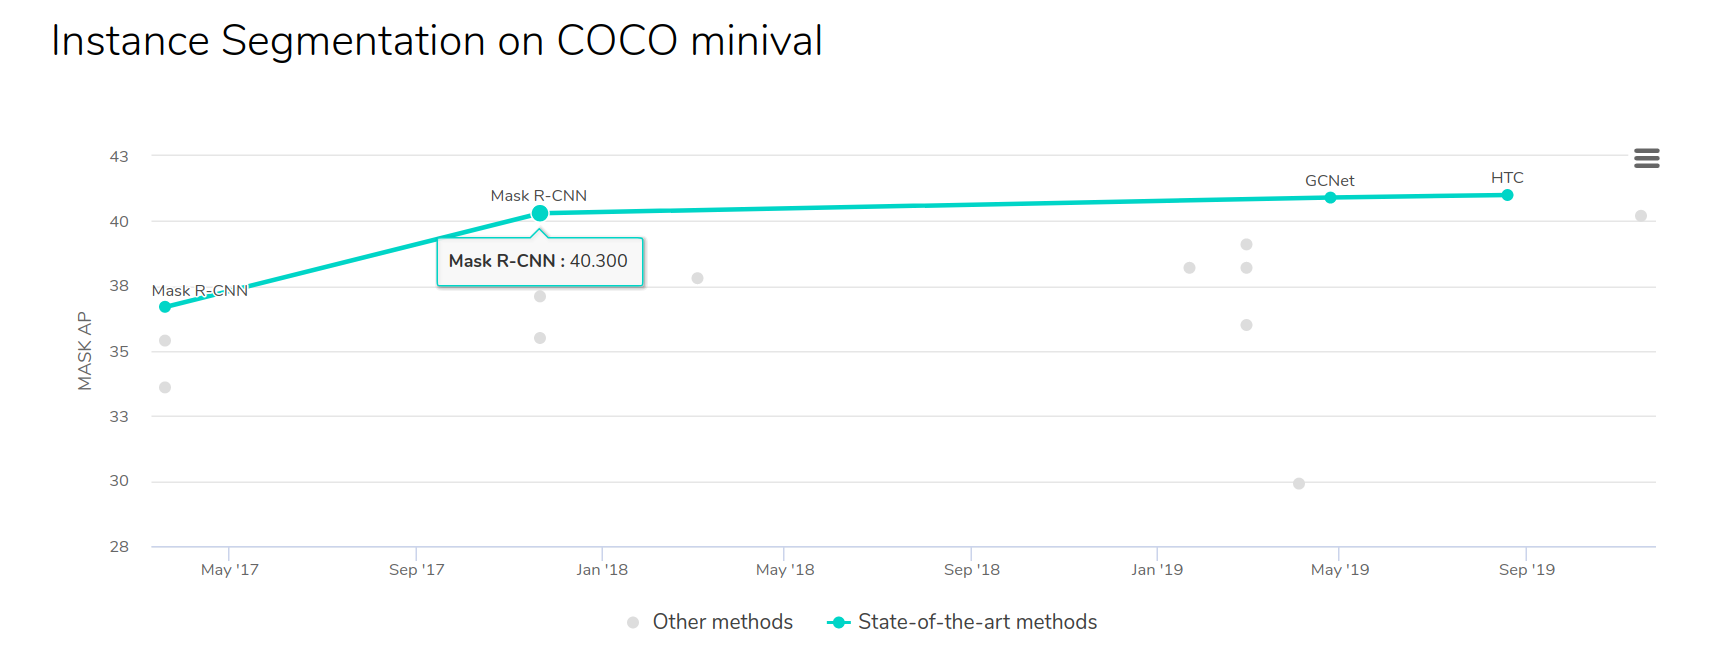

In [5]:
#clonning the model and it's pretrained on COCO dataset weights
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [6]:
sys.path.append(str(ROOT_PATH + '/Mask_RCNN'))
initial_weights_path = ROOT_PATH + "/weights/mask_rcnn_coco.h5"

In [7]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn.config import Config

Using TensorFlow backend.


## Creating configuration files

In [8]:
class TrainingConfig(Config):
    """Configuration used to train the model on Kaggle kernels"""
    NAME = "fashion"
    NUM_CLASSES = CLASS_NUM + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = TrainingConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class TestingConfig(TrainingConfig):
    """Configuration used to test the model locally, using the pretrained weights"""
    IMAGES_PER_GPU = 1

testing_config = TestingConfig()

## Creating Datasets for the model

In [10]:
with open(DATA_PATH + "/label_descriptions.json") as file:
    label_descriptions = json.load(file)

label_names = [x['name'] for x in label_descriptions['categories']]

In [11]:
segment_df = pd.read_csv(DATA_PATH + "/train.csv")

In [12]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]  # 10(classId)_1_2_3(attributeIds) => 10
segment_df.sample(10)

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
274123,d4516b433caa673747f35c19ed94d370.jpg,21934533 2 21942483 5 21950432 9 21958381 13 2...,7952,5304,24,24
179404,8b3694aa0bd4c91392a88d8a153ff8da.jpg,934150 1 936810 3 939470 5 942130 7 944789 10 ...,2660,1300,44,44
307007,edefa6ba152f97696ddcb96bfe0b1f48.jpg,952339 3 953537 8 954736 11 955935 13 957134 1...,1200,1800,22,22
98625,4bcf404693ccfa1eee5274d3851def7f.jpg,114209 22 114618 49 115044 58 115471 66 115897...,426,426,31,31
49047,25d19227c6d0c0ac7d2ab8a9ecc2ca91.jpg,2161558 15 2161775 3 2162224 3 2165011 44 2165...,3456,2304,31,31
122976,5f798370f93d4f50de282954206a0027.jpg,2488080 3 2491078 6 2494076 7 2497074 8 250007...,3000,2001,33,33
323369,fa1607fba97dd47d889e0c8eb0a82624.jpg,13740373 84 13745667 177 13750961 196 13756255...,5304,7952,31,31
1862,0180c5bbfcd5a0bf843dce7ddebee9eb.jpg,964710 2 966907 5 969104 8 971301 11 973498 14...,2200,1467,35,35
86997,433861d2fa789becdbbc3b0eb961201b.jpg,662533 16 665364 47 668195 78 671039 96 673895...,2860,2288,4,4
204662,9e177507742715b3e2b65da1eee014b4.jpg,95263 23 95898 57 96544 73 97189 83 97835 92 9...,650,433,10,10


As we see, one image may have multiple attributes. So we grup them up

In [13]:
segment_df = segment_df.set_index("ImageId")
train_idxs, test_idxs = train_test_split(np.unique(segment_df.index.values), test_size=0.2, random_state=42, shuffle=True)

train_df_raw = segment_df.loc[train_idxs]
test_df_raw = segment_df.loc[test_idxs]

In [14]:
train_image_df = train_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
train_size_df = train_df_raw.groupby('ImageId')['Height', 'Width'].mean()
train_image_df = train_image_df.join(train_size_df, on='ImageId')

print("Total train images: ", len(train_image_df))
train_image_df.head()

Total train images:  36156


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
00048c3a2fb9c29340473c4cfc06424a.jpg,[239016 3 239989 6 240963 7 241938 8 242913 9 ...,"[13, 1, 33, 8, 35, 24, 23, 23]",975,650
0006ea84499fd9a06fefbdf47a5eb4c0.jpg,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,"[1, 33, 8, 23, 23]",1000,667


In [15]:
test_image_df = test_df_raw.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
test_size_df = test_df_raw.groupby('ImageId')['Height', 'Width'].mean()
test_image_df = test_image_df.join(test_size_df, on='ImageId')

print("Total test images: ", len(test_image_df))
test_image_df.head()

Total test images:  9039


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500
000775b6b5e27b011dc8bba2d7b85211.jpg,[426259 9 427858 12 429457 14 431056 17 432655...,"[33, 1, 19, 6, 31, 31]",1600,1067
000cd2e13d1bdd28f480304d7bb9e1ca.jpg,[1522034 13 1525024 39 1528014 64 1531004 90 1...,"[1, 31, 28, 7, 35, 23, 23, 37, 37]",3000,2000
0017af9f7fa8ce9e7558bb924cec324e.jpg,[169688 9 171477 25 173265 43 175053 60 176841...,"[6, 1, 31, 31, 33]",1797,607


In [16]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Redefining *utils.Dataset* for our use case

In [17]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_PATH + '/train/'+ row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMG_SIZE, IMG_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Image and their masks examples 

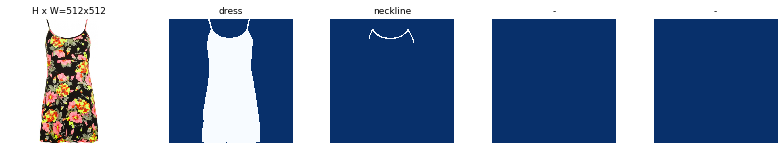

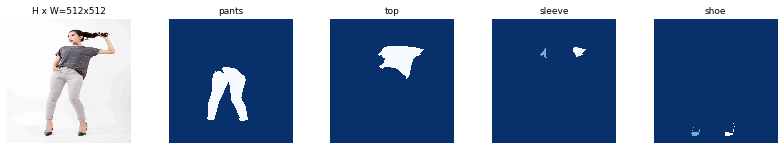

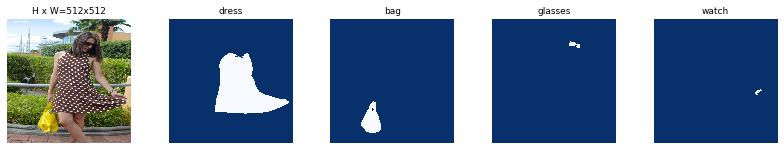

In [18]:
dataset = FashionDataset(train_image_df)
dataset.prepare()

test_dataset = FashionDataset(test_image_df)
test_dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Partitioning data into train and validation sets. Since we can't validate our prediction using Kaggle, we'll calculate final validation score using 20% of the train data

In [19]:
# since we want to test our model on the data it never saw, we'll split it
train_df, valid_df = train_test_split(train_image_df, test_size=0.2, random_state=42, shuffle=True)

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's check the class distribution of the splitted datasets

Total train images:  28924
Total train segments:  212287


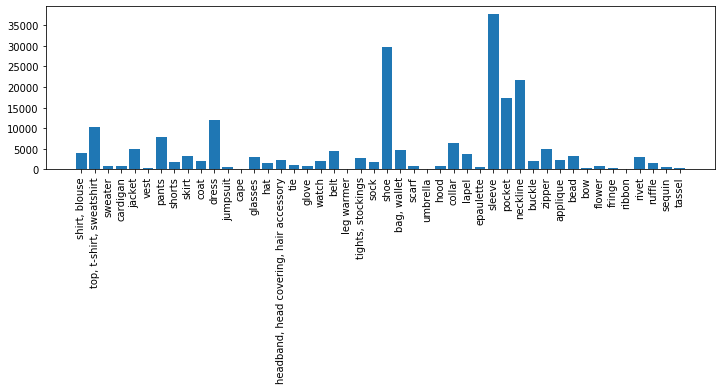

Total validation images:  7232
Total validation segments:  52662


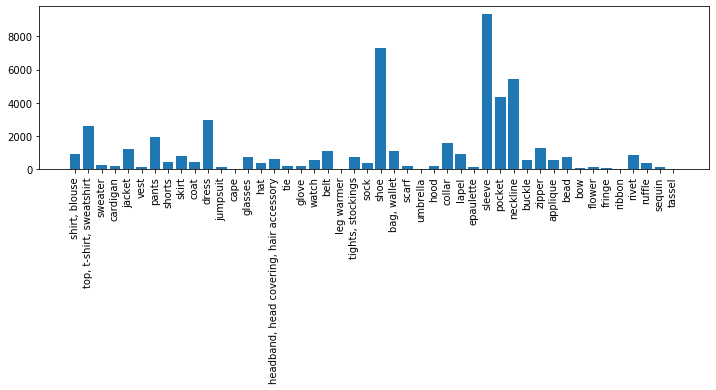

In [20]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total validation images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Training

Taking into account similarities between COCO and iMaterialist datasets, we've decided to use Transfer Learning and to use pre-trained weights of the Mask R-CNN model. We've trained only the top part of our model for 10 epochs. Because each epoch took more than 1 hour to finish, we did that is a few kernel sessions, gradually decreasing learning rate as we came closer to loss minimum. We used the following learning rate scheduler:
```
lr = 1e-2
if epochs > 6: 
    lr = lr ∗ 0.1 
if epochs > 8: 
    lr = lr ∗ 0.1 
if epochs == 10: 
    lr = lr ∗ 0.1```

In [21]:
weights_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0007.h5"

To make our model more robust and diversify our dataset we've used image augmentations:

In [22]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flip
    iaa.Multiply((0.3, 1.2), per_channel=0.5), # change brightness of images (30-120% of original value)
    iaa.ContrastNormalization((0.3, 1.2), per_channel=0.5),
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.arithmetic.JpegCompression((80, 90))
])

In [23]:
# model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_PATH)

# #loading weights from previous epoch
# model.load_weights(weights_path, by_name=True)

In [24]:
# model.train(train_dataset, valid_dataset,
#         learning_rate=lr,
#         epochs=epochs,
#         layers='heads',
#         augmentation=augmentation)

```Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
Epoch 8/10
1000/1000 [==============================] - 2440s 2s/step - loss: 2.8838 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.0405 - mrcnn_class_loss: 0.5922 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.5982 - val_loss: 2.6346 - val_rpn_class_loss: 0.0930 - val_rpn_bbox_loss: 1.1380 - val_mrcnn_class_loss: 0.5197 - val_mrcnn_bbox_loss: 0.4304 - val_mrcnn_mask_loss: 0.4535
Epoch 9/10
1000/1000 [==============================] - 2095s 2s/step - loss: 2.4895 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.9998 - mrcnn_class_loss: 0.4837 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4615 - val_loss: 2.1939 - val_rpn_class_loss: 0.0790 - val_rpn_bbox_loss: 0.8786 - val_mrcnn_class_loss: 0.4575 - val_mrcnn_bbox_loss: 0.3915 - val_mrcnn_mask_loss: 0.3873
Epoch 10/10
1000/1000 [==============================] - 2224s 2s/step - loss: 2.4348 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 1.0466 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.4320 - val_loss: 2.0614 - val_rpn_class_loss: 0.0791 - val_rpn_bbox_loss: 0.8100 - val_mrcnn_class_loss: 0.4405 - val_mrcnn_bbox_loss: 0.3720 - val_mrcnn_mask_loss: 0.3599
CPU times: user 26min 42s, sys: 2min 20s, total: 29min 3s
Wall time: 1h 55min 13s```

## Testing

In [25]:
model_path = ROOT_PATH + "/weights/mask_rcnn_fashion_0007.h5"

model = modellib.MaskRCNN(mode='inference', 
                          config=testing_config,
                          model_dir=ROOT_PATH)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0124 18:41:44.799522 140335932905280 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0124 18:41:44.817879 140335932905280 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0124 18:41:44.820919 140335932905280 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0124 18:41:44.851902 140335932905280 deprecation_wrapper.py:119] From /home/vzalevskyi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.

Loading weights from  /home/vzalevskyi/git/int20th_selection/weights/mask_rcnn_fashion_0007.h5


#### Some helper functions to get EncodedPixels from masks

In [26]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle


# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [27]:
# number of images to predict from the test set
num_to_predict = 1000

# or to select all (~9k)
# num_to_predict= len(test_idxs)

In [28]:
%%time

# predictions themselves

sub_list = []
missing_count = 0
for i, row in enumerate(tqdm(test_image_df.index.values[:num_to_predict])):
    
    image = resize_image(DATA_PATH + '/train/'+ row)
    
    result = model.detect([image])[0]
    
    if result['masks'].size > 0:
        
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row, ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row, '1 1', 23])
        missing_count += 1

100%|██████████| 1000/1000 [05:58<00:00,  2.33it/s]

CPU times: user 30min 48s, sys: 41.9 s, total: 31min 30s
Wall time: 5min 58s


In [36]:
prediction_df = pd.DataFrame(sub_list, columns=['ImageId', "EncodedPixels", 'CategoryId'])
print("Total image results: ", prediction_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
prediction_df.head()

Total image results:  1000
Missing Images:  9


,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,105068 1 105575 7 106087 11 106599 11 107111 1...,33
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,58794 23 59292 43 59629 17 59783 67 60132 232 ...,31
2,0000fe7c9191fba733c8a69cfaf962b7.jpg,169371 12 169880 21 170343 17 170390 26 170849...,31
3,0004467156e47b0eb6de4aa6479cbd15.jpg,95664 13 96157 39 96665 47 97173 54 97682 59 9...,10
4,0004467156e47b0eb6de4aa6479cbd15.jpg,150187 1 150699 1 152742 2 153253 3 153765 3 1...,33


In [37]:
prediction_df.to_csv(f"predictions_{num_to_predict}_007.csv", index=False)

In [39]:
prediction_df = pd.read_csv(f"predictions_{num_to_predict}_007.csv", index_col="ImageId")

In [40]:
prediction_df = prediction_df.rename({"ClassId":"CategoryId"}, axis=1)
prediction_df.head()

,EncodedPixels,CategoryId
ImageId,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,105068 1 105575 7 106087 11 106599 11 107111 1...,33
0000fe7c9191fba733c8a69cfaf962b7.jpg,58794 23 59292 43 59629 17 59783 67 60132 232 ...,31
0000fe7c9191fba733c8a69cfaf962b7.jpg,169371 12 169880 21 170343 17 170390 26 170849...,31
0004467156e47b0eb6de4aa6479cbd15.jpg,95664 13 96157 39 96665 47 97173 54 97682 59 9...,10
0004467156e47b0eb6de4aa6479cbd15.jpg,150187 1 150699 1 152742 2 153253 3 153765 3 1...,33


In [41]:
print("Masks detected:", len(prediction_df)) 
print("Images predicted:", len(np.unique(prediction_df.index.values)))

Masks detected: 5327
Images predicted: 1000


Let's visualise results!

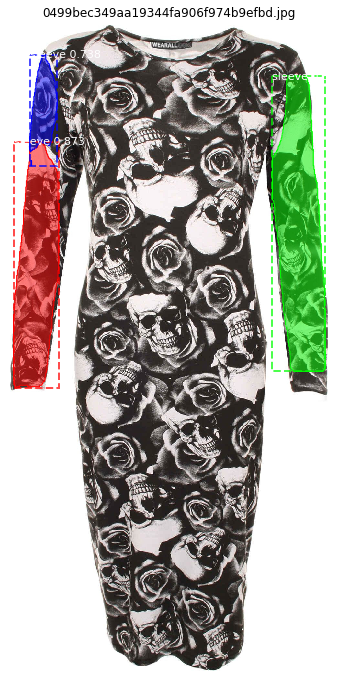

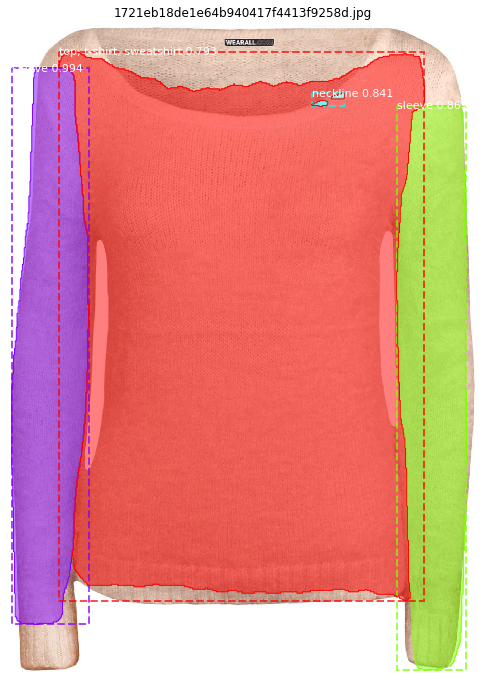

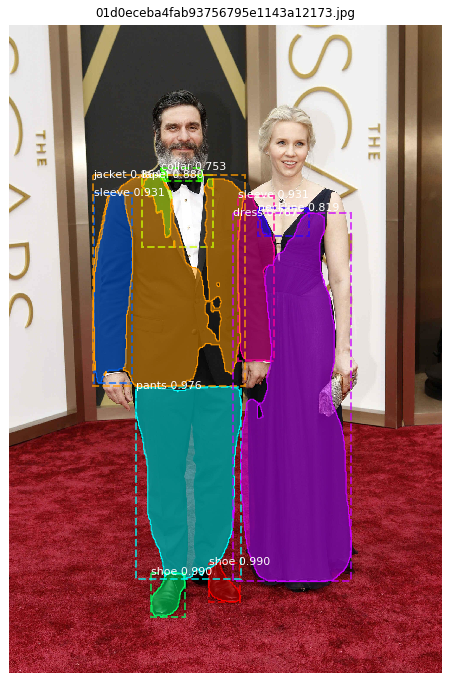

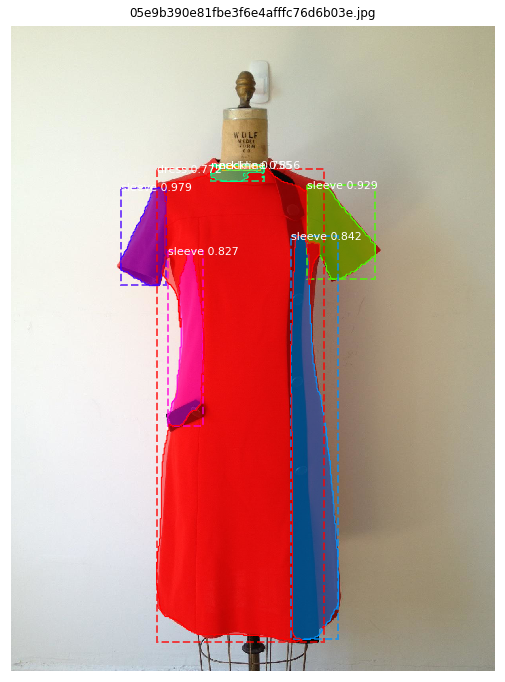

In [42]:
for i in range(4):
    image_id = prediction_df.sample().index.values[0]
    image_path = str(DATA_PATH + '/train/'+ image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMG_SIZE
        x_scale = img.shape[1]/IMG_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        print(image_id)
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

## Evaluating the model

In [43]:
# calculating ground_truth encoded pixels relativly to 512x512 size
gt_list = []

for idx in tqdm(range(num_to_predict)):
    image, image_meta, gt_class_id, gt_roi, gt_mask = modellib.load_image_gt(test_dataset, 
                                                                              TestingConfig, 
                                                                              idx)
    masks, _ = refine_masks(gt_mask, gt_roi)
    for m in range(masks.shape[-1]):

        mask = masks[:, :, m].ravel(order='F')
        rle = to_rle(mask)
        label = gt_class_id[m] - 1
        gt_list.append([test_idxs[idx], ' '.join(list(map(str, rle))), label])

100%|██████████| 1000/1000 [07:25<00:00,  1.51it/s]


In [44]:
gt_df = pd.DataFrame(gt_list)
gt_df = gt_df.rename({0:"ImageId", 1:"EncodedPixels", 2:"CategoryId"}, axis=1).set_index("ImageId")

#### Helper functions to compute comtetion's metric

In [45]:
def calc_IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

def calc_IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_to_mask(data['EncodedPixels_gt'].split(), (int(data['Height']), int(data['Width'])))
    mask_pred = rle_to_mask(data['EncodedPixels_pred'].split(), (int(data['Height']), int(data['Width'])))
    return calc_IoU(mask_gt, mask_pred)

def evaluation(gt_df, pred_df):
    eval_df = pd.merge(gt_df, pred_df, how='outer', on=['ImageId', 'CategoryId'], suffixes=['_gt', '_pred'])
    #return eval_df
    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    
    IoU = eval_df[idx_].apply(calc_IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_gt'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        maybe_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp_IoU = fp + maybe_fp

        # Calculate evaluation score
        score = tp / (tp + fp_IoU + fn)
        scores.append(score)
        print(f"Threshold: {th}, Precision: {score}, TP: {tp}, FP: {fp_IoU}, FN: {fn}")

    mean_score = sum(scores) / len(threshold_IoU)
    print(f"Mean precision score: {mean_score}")

In [46]:
# check that there is equal amount of images in gt_df and predicted_df
assert len(np.unique(prediction_df.index.values)) == len(np.unique(gt_df.index.values))

In [47]:
gt_df["CategoryId"] = gt_df["CategoryId"].astype("int64")

gt_df["Height"] = 512
gt_df["Width"] = 512

prediction_df = prediction_df.reset_index()
gt_df = gt_df.reset_index()

In [48]:
prediction_df.sample(10)

,ImageId,EncodedPixels,CategoryId
501,0298459b657b02a335529e7df32d8d45.jpg,124870 2 125379 6 125890 7 126401 8 126910 11 ...,23
739,03aeb93a2e8fad484915ae155cbee93e.jpg,158891 32 159397 41 159893 60 160391 76 160898...,31
4481,16f7f04d98d789016e9d66bc66739d0c.jpg,94861 2 95373 2 95884 3 96396 3 96908 3 97420 ...,33
223,017ca1b69f3df7ec4d048f6545c60395.jpg,106713 25 107218 41 107727 46 108237 50 108747...,10
1327,0707c6582307577e9161fd5379441dbc.jpg,165669 16 166174 28 166687 30 167204 29 167236...,31
3015,0f6ff6066489017c55664bcc6d56ff6f.jpg,174866 9 175375 32 175440 6 175885 77 176396 8...,31
3565,1233dbfb310abae867355072c29eb13e.jpg,63601 40 64072 17 64099 63 64575 101 65083 107...,1
382,01f60050a2493aa13ec4a2e1bd2e3d10.jpg,156835 1 157347 1 157858 4 157918 11 158370 10...,31
1061,057d219cc81cd8f8c42c1c9455d8f070.jpg,101973 6 101980 1 102483 1 102485 6 102492 1 1...,13
1168,063f5a09917201266d0130c0e1b02a0b.jpg,73955 29 74453 58 74965 65 75476 72 75988 80 7...,10


In [49]:
gt_df.sample(10)

,ImageId,EncodedPixels,CategoryId,Height,Width
4083,d70fc4b4f7f28c5e6315ee6dabc6cc47.jpg,172599 2 173109 4 173621 5 174133 5 174644 6 1...,15,512,512
1778,85df4a890d56a7af009a42d9b1f39c3c.jpg,60178 5 60700 6 61219 1 61734 1 68428 1 69365 ...,0,512,512
2876,523a978a2a09742b03e60b89fc4f21f7.jpg,101582 10 102089 25 102600 27 103110 30 103621...,31,512,512
2462,ae52196b651fd54556cab371c5b0215d.jpg,101062 1 101574 1 102085 2 102597 3 103108 4 1...,35,512,512
2654,15a27f375cef81c29982efe51f77e631.jpg,172767 4 173275 9 173787 9 174299 8 174812 6 1...,31,512,512
1723,ab8d3a282f0eb3e2281b59743fb10a81.jpg,136301 11 136808 19 137318 23 137827 28 138337...,29,512,512
4582,2160b259616da3094c8aa3d24e7d1144.jpg,106165 3 106671 16 107177 22 107684 28 108180 ...,31,512,512
762,949e374082901beb7aada90ecaa5e4b1.jpg,133765 2 134278 7 134790 10 135302 14 135814 1...,1,512,512
4575,309943d037a0ff4a32b1d401ef09d6b6.jpg,164012 2 164520 7 165028 13 165535 22 166043 3...,31,512,512
1763,fc2b7868833800269f26863c22cebe13.jpg,120652 4 121163 6 121674 7,35,512,512


In [50]:
%%time
evaluation(gt_df, prediction_df)

Threshold: 0.5, Precision: 0.0003961965134706815, TP: 5, FP: 5510, FN: 7105
Threshold: 0.55, Precision: 0.00023771790808240888, TP: 3, FP: 5512, FN: 7105
Threshold: 0.6, Precision: 0.0001584786053882726, TP: 2, FP: 5513, FN: 7105
Threshold: 0.65, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.7, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.75, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.8, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.85, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.9, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Threshold: 0.95, Precision: 0.0, TP: 0, FP: 5515, FN: 7105
Mean precision score: 7.92393026941363e-05
CPU times: user 896 ms, sys: 43 µs, total: 896 ms
Wall time: 894 ms


In [51]:
7.92393026941363e-05

7.92393026941363e-05